In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from PIL import Image
import cv2
from glob import glob
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Conv3D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

2025-06-17 23:20:51.769447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750202451.972735      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750202452.029422      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# The Project  
This project is part of Kaggle competition https://www.kaggle.com/c/histopathologic-cancer-detection/overview   
It aims to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.   
The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (without duplicates).  
This dataset was provided by Bas Veeling, with additional input from Babak Ehteshami Bejnordi, Geert Litjens, and Jeroen van der Laak.  
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target

# Meeting the Data (EDA)
Let's check the data  

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


(220025, 2)
label
0    130908
1     89117
Name: count, dtype: int64
label
0    0.594969
1    0.405031
Name: proportion, dtype: float64
Absent values:
id       0
label    0
dtype: int64


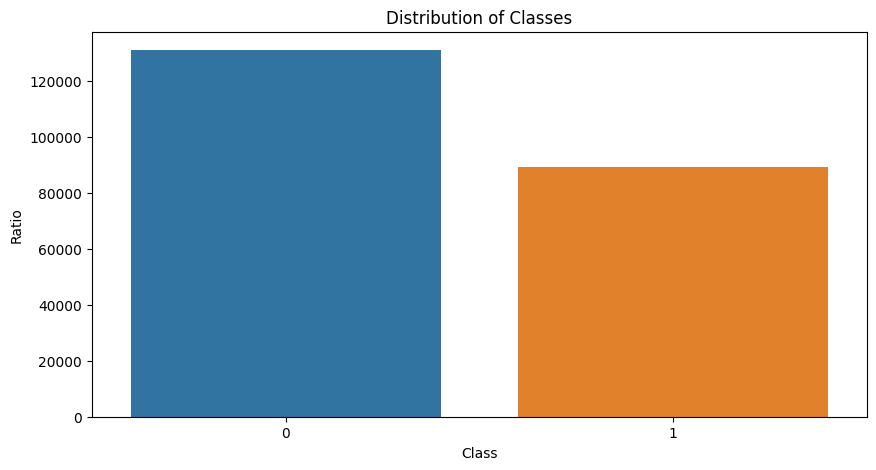

In [2]:
labels_path = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'

labels = pd.read_csv(labels_path)
display(labels.head())
print(labels.shape)
print(labels['label'].value_counts())
print(labels['label'].value_counts(normalize=True))
print(f'Absent values:\n{labels.isnull().sum()}')

# Histogram for classes
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=labels, order=labels['label'].value_counts().index)
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Ratio')
plt.xticks(rotation=0)
plt.show()

Image 1: d293308913e4a40cebb809d986aa9add65a76bfa, Size: 96x96:9216
Label: 0


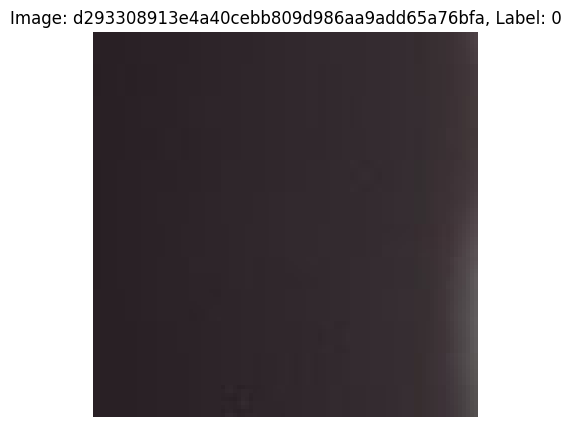

Image 2: fcd55f03496afb4b11598d9c2231e86da318e723, Size: 96x96:9216
Label: 1


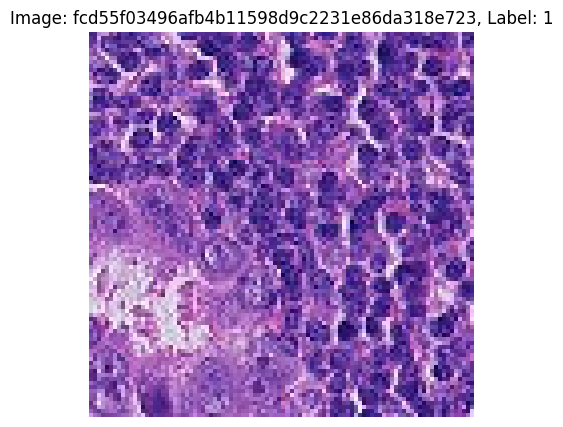

Image 3: 5c983c8f14afeffdb098b9f3cbb68488a802b957, Size: 96x96:9216
Label: 0


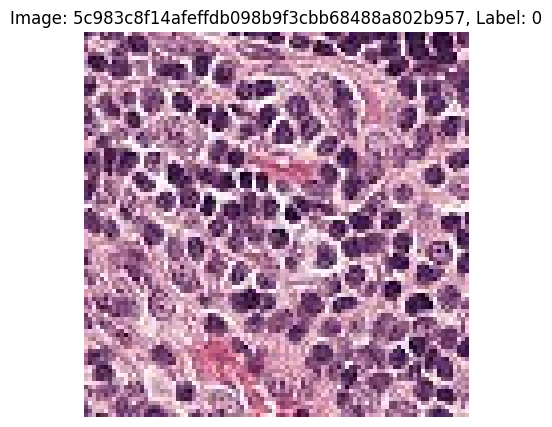

Image 4: 71bf03e8530348e57ec07d8ce2052f215390c997, Size: 96x96:9216
Label: 0


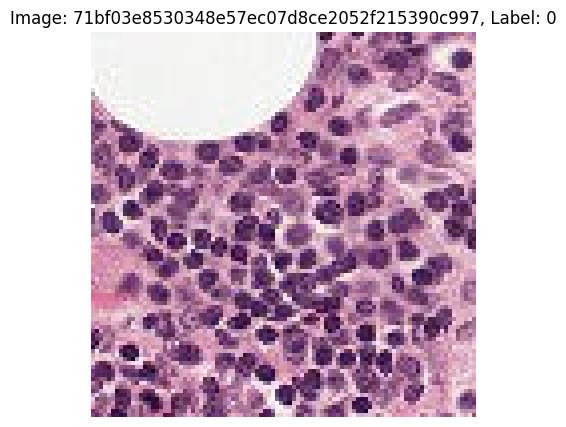

Image 5: 1533406000e26663c5fadac3bcc3e38285a45bb3, Size: 96x96:9216
Label: 1


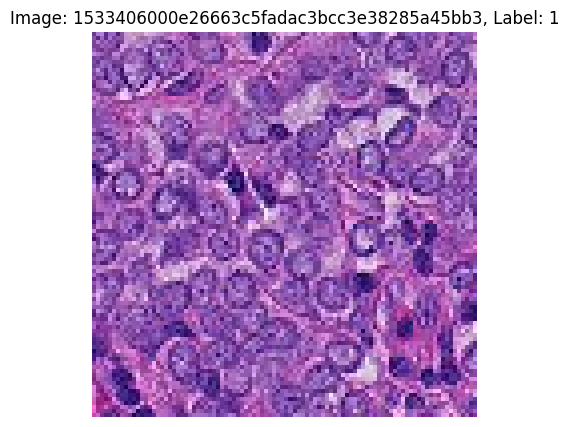

In [3]:
train_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'

samples = labels.sample(5, random_state=42)
for idx, img_name in enumerate(samples['id']):
    img_path = os.path.join(train_dir, img_name + '.tif')
    img = Image.open(img_path)
    img_height, img_width = img.size
    print(f'Image {idx + 1}: {img_name}, Size: {img_width}x{img_height}:{img.width*img.height}')
    print(f'Label: {samples.iloc[idx]["label"]}')
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.title(f'Image: {img_name}, Label: {samples.iloc[idx]["label"]}')
    plt.axis('off')
    plt.show()


In [4]:
def count_images(directory):
    return len(glob(os.path.join(directory, '*.tif')))
train_count = count_images(train_dir)
test_count = count_images(test_dir)
print(f'Train images: {train_count}')
print(f'Test images: {test_count}')

Train images: 220025
Test images: 57458


In [5]:
train_labels, val_labels = train_test_split(labels, test_size=0.2, random_state=42)
print(f'Train labels: {len(train_labels)}')

Train labels: 176020


### Information about the data  
**Labels**  
The data is relatevely balanced (60% of class 1 and 0)  
Classes:  
1: Contains metastatic tissue  
0: Does not  

**Images**  
Image Size: 96x96 pixels  
Color Channels: 3 (RGB)  
Format: .tif files  

**Datasets**  
Train: 220025  
Test: 57458  

**Preprocessing pipeline**  
- Normilize the iamges  
- Take 10% of train as validation dataset  
- Ensure 96x96 dimensions  

In [6]:
train_labels, val_labels = train_test_split(labels, test_size=0.2, random_state=42)
print(f'Train labels: {len(train_labels)}')

Train labels: 176020


In [7]:
%%time
train_labels['path'] = train_labels['id'] + '.tif'
val_labels['path'] = val_labels['id'] + '.tif'
train_labels['label'] = train_labels['label'].astype('str')
val_labels['label'] = val_labels['label'].astype('str')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)


def create_data_generator(dataframe, directory, datagen, batch_size=64, test=False):
    return datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col='path',
        y_col='label',
        target_size=(96, 96),
        class_mode='binary',
        batch_size=batch_size,
        shuffle=True
    )


train_generator = create_data_generator(train_labels, train_dir, train_datagen)
val_generator = create_data_generator(val_labels, train_dir, val_datagen)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
CPU times: user 3.66 s, sys: 7.16 s, total: 10.8 s
Wall time: 14min 4s


#  Architecture/Training the Models   
The most important architecutre considerations are: 
- (96, 96, 3) is the input shape in the beggining (also it may make sense to remove RGB)  
- sigmoid is the activation function for the ast layer (only one neuron) as it is binary classification  
- otherwise, a few experements with simple and more compelx architecture should be performed

My expirience in creating NN for CV is rather low, so I would go for single change in architecture of models to test those.  

In [8]:
def fit_make_history_and_evaluate_model(model, epochs=5, test_run=False):
    """
    Functio nto automatize compliation of models, their fitting and evaluation
    """
    # Compile
    model.compile(
        optimizer=Adam(learning_rate=0.0001), # the best learning rate so to say
        loss='binary_crossentropy',
        metrics=['accuracy', 'auc']
    )

    # Fit the model
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    if test_run:
        epochs = 1       

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate 
    eval_results = model.evaluate(val_generator, verbose=1)
    print(f'Evaluation results: {eval_results}')

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

    return history, model

I0000 00:00:1750203315.996867      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30752)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,968,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,969,153 (7.51 MB)

 Trainable params: 1,969,153 (7.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


I0000 00:00:1750203321.378830     103 service.cc:148] XLA service 0x7c1f18004610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750203321.379474     103 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750203321.655266     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2751 ━━━━━━━━━━━━━━━━━━━━ 3:43:59 5s/step - accuracy: 0.5781 - auc: 0.4184 - loss: 0.6898

I0000 00:00:1750203323.509503     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 2015s 731ms/step - accuracy: 0.7607 - auc: 0.8223 - loss: 0.5044 - val_accuracy: 0.7533 - val_auc: 0.8328 - val_loss: 0.5936
Epoch 2/5
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 675s 245ms/step - accuracy: 0.7926 - auc: 0.8620 - loss: 0.4531 - val_accuracy: 0.7425 - val_auc: 0.8183 - val_loss: 0.6445
Epoch 3/5
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 624s 227ms/step - accuracy: 0.8011 - auc: 0.8724 - loss: 0.4364 - val_accuracy: 0.7150 - val_auc: 0.7992 - val_loss: 0.7890
Epoch 4/5
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 612s 222ms/step - accuracy: 0.8060 - auc: 0.8765 - loss: 0.4296 - val_accuracy: 0.7450 - val_auc: 0.8204 - val_loss: 0.6661
688/688 ━━━━━━━━━━━━━━━━━━━━ 51s 74ms/step - accuracy: 0.7528 - auc: 0.8312 - loss: 0.5971
Evaluation results: [0.593555748462677, 0.753323495388031, 0.8327652215957642]


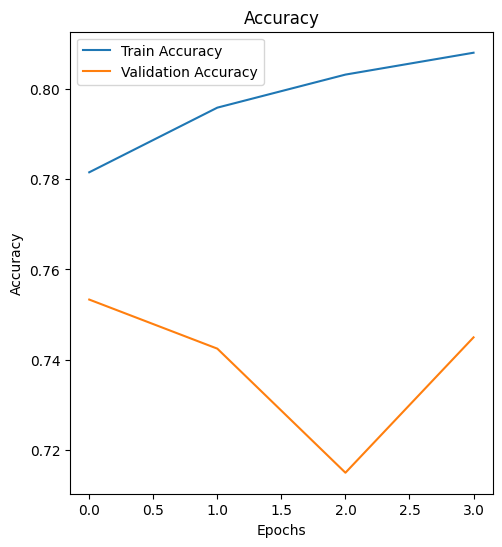

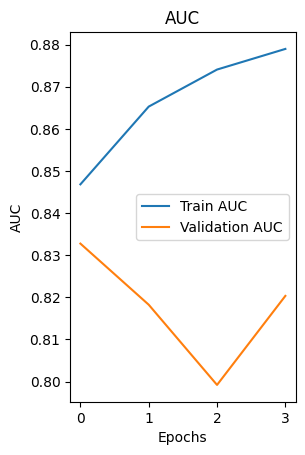

CPU times: user 32min 58s, sys: 1min 33s, total: 34min 31s
Wall time: 1h 6min 21s


In [9]:
%%time
simple_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((3, 3)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
simple_model.summary()
history_simple, simple_model = fit_make_history_and_evaluate_model(simple_model)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 822,337 (3.14 MB)

 Trainable params: 822,337 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 619s 224ms/step - accuracy: 0.7615 - auc: 0.8275 - loss: 0.4976 - val_accuracy: 0.7306 - val_auc: 0.8161 - val_loss: 0.7003
Epoch 2/5
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 610s 222ms/step - accuracy: 0.8007 - auc: 0.8698 - loss: 0.4411 - val_accuracy: 0.7435 - val_auc: 0.8253 - val_loss: 0.6115
Epoch 3/5
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 611s 222ms/step - accuracy: 0.8143 - auc: 0.8833 - loss: 0.4176 - val_accuracy: 0.7420 - val_auc: 0.8619 - val_loss: 0.6052
Epoch 4/5
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 610s 222ms/step - accuracy: 0.8247 - auc: 0.8940 - loss: 0.3995 - val_accuracy: 0.7697 - val_auc: 0.8690 - val_loss: 0.5190
Epoch 5/5
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 661s 240ms/step - accuracy: 0.8313 - auc: 0.9018 - loss: 0.3846 - val_accuracy: 0.7308 - val_auc: 0.8272 - val_loss: 0.6371
688/688 ━━━━━━━━━━━━━━━━━━━━ 52s 76ms/step - accuracy: 0.7693 - auc: 0.8688 - loss: 0.5205
Evaluation results: [0.5190117359161377, 0.769707977771759, 0.8689695000648499]


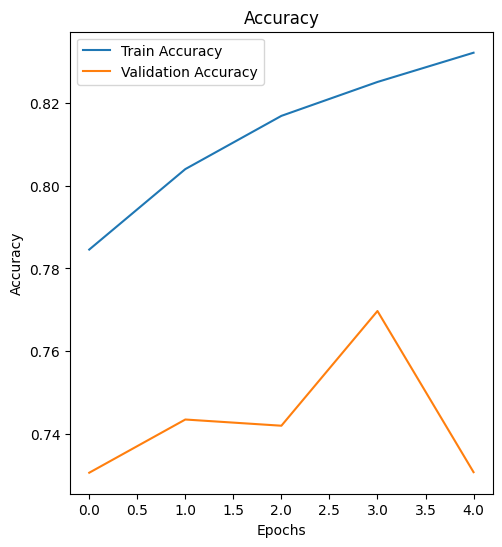

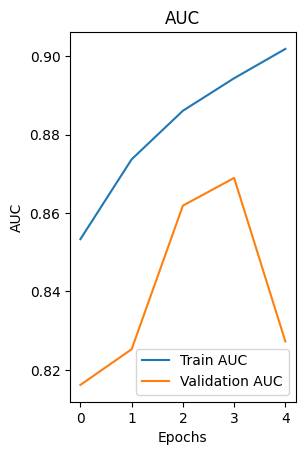

CPU times: user 41min 27s, sys: 1min 42s, total: 43min 9s
Wall time: 52min 44s


In [10]:
%%time

second_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((3, 3)),

    Conv2D(64, (3, 3), activation='relu'), # 2 Convolutions
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
second_model.summary()
history_second, second_model = fit_make_history_and_evaluate_model(second_model)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 822,337 (3.14 MB)

 Trainable params: 822,337 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 681s 246ms/step - accuracy: 0.7547 - auc: 0.8178 - loss: 0.5052 - val_accuracy: 0.7312 - val_auc: 0.8144 - val_loss: 0.6212
Epoch 2/5
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 651s 237ms/step - accuracy: 0.7993 - auc: 0.8682 - loss: 0.4425 - val_accuracy: 0.7531 - val_auc: 0.8512 - val_loss: 0.5675
Epoch 3/5
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 611s 222ms/step - accuracy: 0.8067 - auc: 0.8763 - loss: 0.4293 - val_accuracy: 0.7047 - val_auc: 0.8347 - val_loss: 0.6533
Epoch 4/5
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 600s 218ms/step - accuracy: 0.8179 - auc: 0.8888 - loss: 0.4086 - val_accuracy: 0.7656 - val_auc: 0.8529 - val_loss: 0.5152
Epoch 5/5
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 603s 219ms/step - accuracy: 0.8291 - auc: 0.8993 - loss: 0.3903 - val_accuracy: 0.7861 - val_auc: 0.8817 - val_loss: 0.4682
688/688 ━━━━━━━━━━━━━━━━━━━━ 53s 76ms/step - accuracy: 0.7910 - auc: 0.8823 - loss: 0.4622
Evaluation results: [0.46817588806152344, 0.7860924601554871, 0.881685733795166]


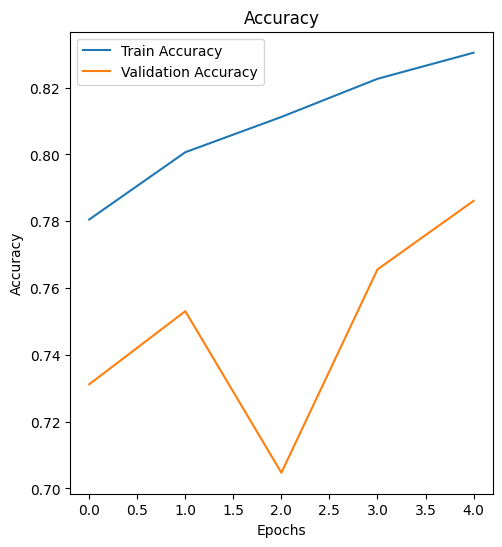

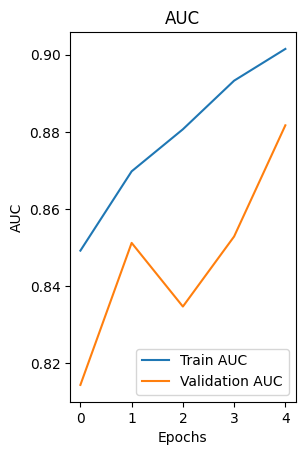

CPU times: user 41min 27s, sys: 1min 43s, total: 43min 10s
Wall time: 53min 20s


In [11]:
%%time
third_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((3, 3)),

    Conv2D(64, (3, 3), activation='relu'), # 2 Convolutions
    MaxPooling2D((2, 2)),

    Flatten(),
    Dropout(0.5), # And dropout
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
third_model.summary()
history_third, third_model = fit_make_history_and_evaluate_model(third_model)

# Results and Analysis 
I tried several variations of NN architecture. With introduction of an additional convolutional layer, the results imporved.  
On the other hand, introductio nof dropout did not increase the performance.  

| ROC-AUC | Model             |
|---------|------------------|
| 0.83    | One layer         |
| 0.86    | Two layers        |
| 0.88    | With dropout      |


In [13]:
def make_test_predictions(model, test_dir, name, batch_size=64):
    """
    To make predictions on test
    """
    test_paths = glob(os.path.join(test_dir, '*.tif'))
    test_df = pd.DataFrame({'path': test_paths})
    test_df['id'] = test_df['path'].apply(lambda path: os.path.splitext(os.path.basename(path))[0])
    
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='path',
        y_col=None,
        target_size=(96, 96),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False
    )

    test_preds = model.predict(test_generator, verbose=1)
    test_preds_binary = (test_preds > 0.5).astype(int).flatten()

    submission = pd.DataFrame({
        'id': test_df['id'],
        'label': test_preds_binary
    })

    print(submission.head())
    submission.to_csv(f'/kaggle/working/submission_{name}.csv', index=False)
    print(f"Submission file for {name} created successfully.")

make_test_predictions(simple_model, test_dir, 'simple_model')
make_test_predictions(second_model, test_dir, 'second_model')
make_test_predictions(third_model, test_dir, 'third_model')

Found 57458 validated image filenames.
898/898 ━━━━━━━━━━━━━━━━━━━━ 342s 381ms/step
                                         id  label
0  a7ea26360815d8492433b14cd8318607bcf99d9e      0
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664      0
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb      0
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0      1
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62      0
Submission file for simple_model created successfully.
Found 57458 validated image filenames.
898/898 ━━━━━━━━━━━━━━━━━━━━ 73s 81ms/step
                                         id  label
0  a7ea26360815d8492433b14cd8318607bcf99d9e      0
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664      0
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb      0
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0      0
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62      0
Submission file for second_model created successfully.
Found 57458 validated image filenames.
898/898 ━━━━━━━━━━━━━━━━━━━━ 71s 79ms/step
                              

# Conclusion  
I belive that more experements with different architecture would be beneficial.  
One of my biggest problems with this projet was that the whole time needed for the notebook to run is about 4 hours, so it made it impossible to make many experiments, which would be nice.  
Additional manipulations with the images could also benefit the ouput highly.  
My best score on the test dataset on Kaggle was 0.7, while there are many submitions with almost 1.  
Celearly, there is a room for improvement, howeverh I have gaiind hands-on expirience with neural nets for images, something I have never done before.

In [14]:
import os
print("Files in /kaggle/working/:")
print(os.listdir('/kaggle/working/'))

Files in /kaggle/working/:
['submission_second_model.csv', '.virtual_documents', 'submission_simple_model.csv', 'submission_third_model.csv']
